# Global Mean Surface Temperature

*Adapted from:* https://github.com/pangeo-gallery/cmip6/blob/master/global_mean_surface_temp.ipynb

In [40]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import cartopy.crs as ccrs


%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [10]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [11]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

/opt/anaconda3/lib/python3.8/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CAS-ESM2-0,3,1,1
CESM2-WACCM,3,1,1
CIESM,3,1,1
CMCC-CM2-SR5,3,1,1
CMCC-ESM2,3,1,1


Let's have a look at the bias for temperature and precipitation for CMIP6 data:
https://esmvaltool.dkrz.de/shared/esmvaltool/climate4impact/?project=CMIP6

Let's play with the following models:
- EC-Earth3
- GISS-E2-2-G
- FGOALS-g3
- GISS-E2-1-H
- E3SM-1-1
- E3SM-1-0
- IITM-ESM
- CAMS-CSM1-0
- MPI-ESM1-2-LR
- CanESM5
- ACCESS-ESM1-5

### EC-EARTH3

1. Donwload the data using the ESGF interface
2. Have a look at the historical monthly mean temperature: 
    - calculate and plot the temporal mean --> mean temperatures in the world
    - calculate the global mean (weighted)
    - plot the temporal evolution of the global mean temperature
3. Have a look at the future monthly mean temperature for scenarios ssp245 and ssp585
    - plot the temporal mean --> mean temperatures in the world
    - calculate the differences between Mid-Century and End-Century. Play with different consistent periods
    - calculate the global mean (weighted)
    - plot the temporal evolution of the global mean temperature for past and the two future scenarios 
   
4. Let's divide in groups and work with different regions compere the regional statistics with the global ones: mean, max, min

In [12]:
from utils import esgf_search

In [13]:
result = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='historical',
                  source_id="EC-Earth3", member_id="r1i1p1f1")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?act

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=350
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=360
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=370
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&source_id=EC-Earth3&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=380
https://esgf-node.llnl.gov/esg-search/search

['http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_185001-185012.nc',
 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_185101-185112.nc',
 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_185201-185212.nc',
 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_185301-185312.nc',
 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_1854

In [14]:
# Lets consider 20 years from 1995 to 2014
result[-20:]

['http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_199501-199512.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_199601-199612.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_199701-199712.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_199801-199812.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/tas/gr/v20200310/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_199901-199912.nc',
 'http://e

In [15]:
ds = xr.open_mfdataset(result[-20:], combine='by_coords')
ds

<xarray.Dataset>
Dimensions:    (time: 240, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time:                     0.0
    comment:                         Production: Thomas Reerink at KNMI
    contact:                         cmip6-data@ec-earth.org
    ...                              ...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/ee2c52bb-1561-44fa-9568-91d...
    branch_time_in_child:            0.0D
    branch_time_in_parent:           149749.0D
    history:                         2019-09-26T06:33:30Z ; CMOR rewrote data...
    DODS_EXTRA.Unlimited_Dimension:  time

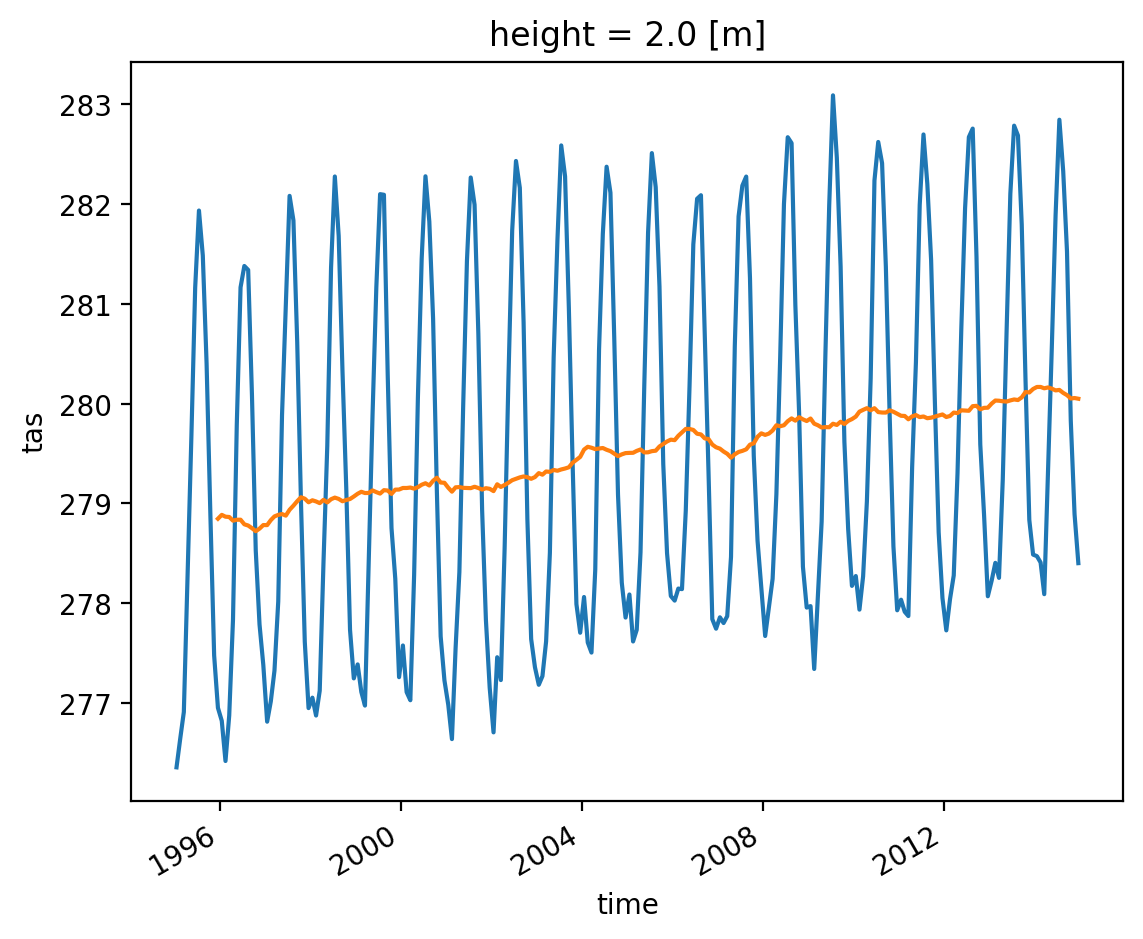

In [20]:
# Flat Earth Mean
flat_mean = ds.tas.mean(['lat', 'lon'])
flat_mean.plot()
flat_mean.rolling(time=12).mean().plot()

In [21]:
# Weighted Mean --> we need the area of the cells

In [23]:
files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                         experiment_id='historical', source_id="EC-Earth3")
ds_area = xr.open_dataset(files_area[0])
ds_area

https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&source_id=EC-Earth3&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


<xarray.Dataset>
Dimensions:    (lat: 256, bnds: 2, lon: 512)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              149749.0
    comment:                            Production: Thomas Reerink at KNMI
    ...                                 ...
    title:                              EC-Earth3 output prepared for CMIP6
    tracking_id:                        hdl:21.14100/cdc286fc-bf7c-452f-a56f-...
    variable_id:                        areacella
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [26]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
temp_weighted = (ds.tas * ds_area.areacella) /  total_area

In [44]:
crs = ccrs.PlateCarree()
p = temp_weighted.isel(time=3).plot(subplot_kws={"projection": crs})
p.axes

TypeError: __init__() takes 2 positional arguments but 4 positional arguments (and 2 keyword-only arguments) were given

Error in callback <function _draw_all_if_interactive at 0x7f84e06ea8b0> (for post_execute):


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 640x480 with 1 Axes>

In [ ]:
flat_mean.plot(label='flat mean')
flat_mean.rolling(time=12).mean().plot(label='rolling 12m flat mean')


### Ensemble

1. Extend the analysis to the different models
2. Calculate the global mean for all models
3. Plot the temporal evolution of each model
4. Plot the ensemble mean and the ensemble std

### Heatwaves indicators

1. Download daily tas data
2. Temperature over 35 degrees
3. Temperature over 40 degrees
4. Days with daily max over 35 degrees
5. Days with daily max over 40 degrees

In [5]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict) 

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [6]:
dsets_ = dask.compute(dict(dsets))[0]

/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/lib/python3.8/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode 

In [7]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [8]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    
    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]
    
    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[################                        ] | 41% Completed | 81m 41ss

In [ ]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

In [ ]:
df_all = big_ds.sel(year=slice(1900, 2100)).to_dataframe().reset_index()
df_all.head()

In [ ]:
sns.relplot(data=df_all,
            x="year", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=2);

In [ ]:
# why are there axis legends for 9, 10 - doesn't make sense
df_all.experiment_id.unique()